# CS306 Homework3 Cluster

### Information
Author: 王超逸 WANG Chaoyi
SID: 11811014

### README: 
My work for the two tasks are in the same notebook file. The implementation of the latter task depends on the necessary imports of the former one and is tested to be all right, so please ensure the step of necessary imports has run when some exceptions occured in task2 if the two tasks were graded separately.

### Reference:


## Task1: Mystery Data
### Necessary imports

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pe
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')

### Read the data, necessary cleaning and preview 

In [67]:
df = pd.read_csv('./HW3_1_data.csv')
# Remove null values (in fact there is not null value);
df.dropna(axis=0, inplace=True)
# Remove duplicates (in fact, no either);
df = df.drop_duplicates()
# Briefly check the data
df.info()
df.describe(include='all')
# df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788 entries, 0 to 787
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      788 non-null    float64
 1   x2      788 non-null    float64
dtypes: float64(2)
memory usage: 18.5 KB


,x1,x2
count,788.000000,788.000000
mean,19.566815,14.171764
std,9.922042,8.089683
min,3.350000,1.950000
25%,11.150000,7.037500
50%,18.225000,11.725000
75%,30.700000,21.962500
max,36.550000,29.150000


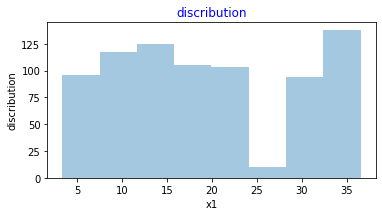

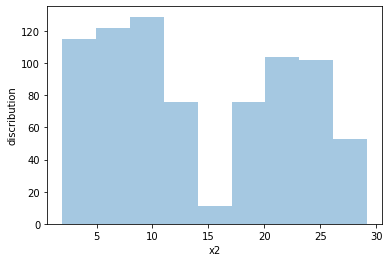

In [68]:
f = plt.figure(figsize=(20,20))
for i ,col in enumerate(df.columns):
    ax = f.add_subplot(6,3,i+1)
    sns.distplot(df[col].ffill(),kde=False)
    ax.set_title('discribution',color = 'blue')
    plt.ylabel('discribution')
    plt.show()
f.tight_layout()

### See the correlation

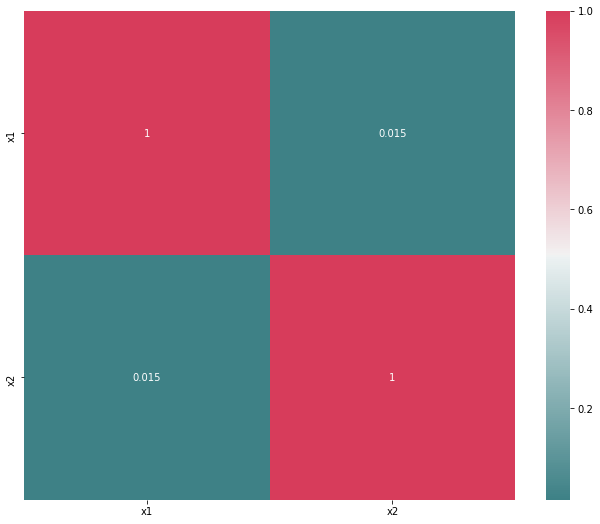

In [69]:
corr = df.corr()
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(200, 5, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.show()

### Standardize the feature

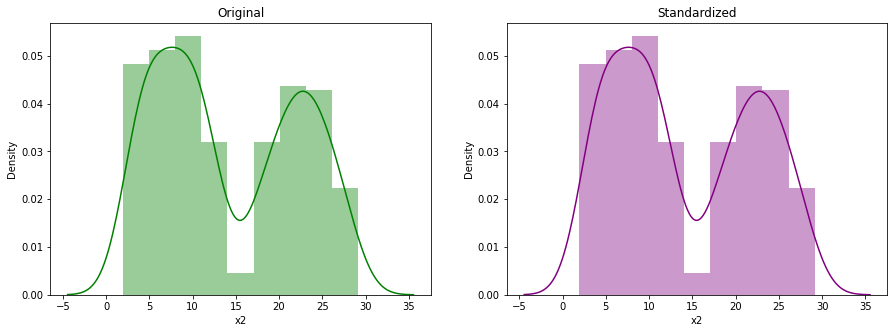

In [70]:
from sklearn.preprocessing import StandardScaler
scaler_df = StandardScaler().fit_transform(df)
type(scaler_df)#numpy.ndarray
df_scaled = pd.DataFrame(scaler_df, columns=df.columns)

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(df['x2'], ax=ax[0], color='green')
ax[0].set_title("Original")
sns.distplot(df['x2'], ax=ax[1], color='purple')
ax[1].set_title("Standardized")
plt.show()
f.tight_layout()#Cool

### k-means clustering

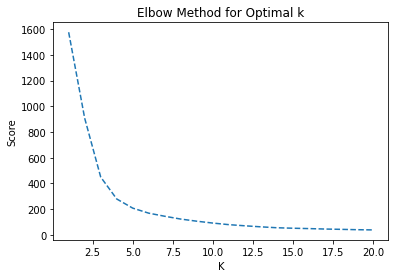

In [71]:
from sklearn.cluster import KMeans
score = []
range_values = range(1, 21)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df_scaled)
    score.append(kmeans.inertia_)

plt.plot(range_values, score, '--')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Elbow Method for Optimal k')
plt.show()
# We should select the value of k at the point after which the inertia decreases in a linear fashion.
# In this case, the k selected is 14. However, the k

### Apply k-means


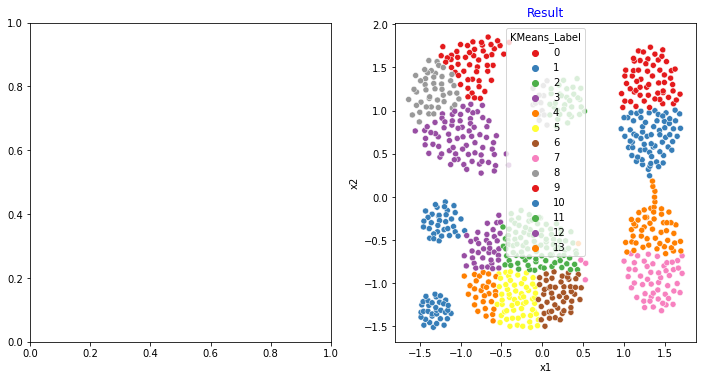

In [84]:
km = KMeans(n_clusters = 14, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km.fit(df_scaled)
cluster_label = km.labels_

df_scaled['KMeans_Label'] = cluster_label
f=plt.figure(figsize=(20,20))
scatter_cols = ['x1','x2']
for i, col in enumerate(scatter_cols):
    ax = f.add_subplot(4,4,i+1)

sns.scatterplot(x=df_scaled['x1'],y=df_scaled['x2'],hue=df_scaled['KMeans_Label'],palette='Set1')
ax.set_title("Result",color='blue')
f.tight_layout()